# Predicting Evergreeness of Content with Decision Trees and Random Forests

## DATA DICTIONARY

In [3]:
import pandas as pd
import json
import seaborn as sb
%matplotlib inline

In [4]:
import pydot

In [5]:
import graphviz

#### Read in the dataset Stumbleupon

In [7]:
data = pd.read_csv("../../assets/dataset/stumbleupon.tsv", sep='\t')
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0


#### Check out one the first article
1. Let's look at the full variable 

In [8]:
#1. 
print data.boilerplate[0] 

{"title":"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries","body":"A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose California Photographer Tony Avelar Bloomberg By 2015 your mobile phone will project a 3 D image of anyone who calls and your laptop will be powered by kinetic energy At least that s what International Business Machines Corp sees in its crystal ball The predictions are part of an annual tradition for the Armonk New York based company which surveys its 3 000 researchers to find five ideas expected to take root in the next five years IBM the world s largest provider of computer services looks to Silicon Valley for input gleaning many ideas from its Almaden research center in San Jose 

### ACTION: Split the big boilerplate variable into it's parts

In [9]:
data['title'] = data.boilerplate.map(lambda abc: json.loads(abc).get('title', ''))
data['title']

0       IBM Sees Holographic Calls Air Breathing Batte...
1       The Fully Electronic Futuristic Starting Gun T...
2       Fruits that Fight the Flu fruits that fight th...
3                     10 Foolproof Tips for Better Sleep 
4       The 50 Coolest Jerseys You Didn t Know Existed...
5                               Genital Herpes Treatment 
6                       fashion lane American Wild Child 
7       Racing For Recovery by Dean Johnson racing for...
8                      Valet The Handbook 31 Days 31 days
9             Cookies and Cream Brownies How Sweet It Is 
10      Business Financial News Breaking US Internatio...
11      A Tip of the Cap to The Greatest Iron Man of T...
12                         9 Foods That Trash Your Teeth 
13                                                       
14      French Onion Steaks with Red Wine Sauce french...
15      Izabel Goulart Swimsuit by Kikidoll 2012 Sport...
16                    Liquid Mountaineering The Awesomer 
17            

### Repeat for the body key

In [8]:
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data['body'].head()

0    A sign stands outside the International Busine...
1    And that can be carried on a plane without the...
2    Apples The most popular source of antioxidants...
3    There was a period in my life when I had a lot...
4    Jersey sales is a curious business Whether you...
Name: body, dtype: object

In [9]:
data['url'] = data.boilerplate.map(lambda a: json.loads(a).get("url", ''))
data['url'].head()

0    bloomberg news 2010 12 23 ibm predicts hologra...
1    popsci technology article 2012 07 electronic f...
2    menshealth health flu fighting fruits cm mmc F...
3    dumblittleman 2007 12 10 foolproof tips for be...
4    bleacherreport articles 1205138 the 50 coolest...
Name: url, dtype: object

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

> ## label is our outcome for this project

In [10]:
data[['url', 'label']].head()

,url,label
0,bloomberg news 2010 12 23 ibm predicts hologra...,0
1,popsci technology article 2012 07 electronic f...,1
2,menshealth health flu fighting fruits cm mmc F...,1
3,dumblittleman 2007 12 10 foolproof tips for be...,1
4,bleacherreport articles 1205138 the 50 coolest...,0


### Exercises to Get Started

> ### Exercise: 1. Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Develop 1-3 of the those features.

### Exercise 1
#### Features that are useful for predicting evergreen websites.

1. Arts. Does the websites include art? Art remains relevant for long periods of time.
2. Science. Science also remains relevant for long periods of time because it is fact. Science is around us.
3. Food. Recipes for certain dishes have been carried from the past throughout history to arrive in the present.
4. Health. People are always looking for tips on how to improve their health.
5. Current Events. Current events (as the name implies) will not be current in a few days. This is helpful for    predicting if something will NOT be evergreen.

### Exercise 2

In order to tell if a website is evergreen, maybe we can assign a score (a number from 1 to 10 with 10 being very evergreen) to every possible feature. A feature that is not evergreen would have a low score and a feature that is evergreen would have a high score.






> ### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [11]:
data.groupby(['is_news'])[['label']].mean()

,label
is_news,
1,0.516916
?,0.507562


> ### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

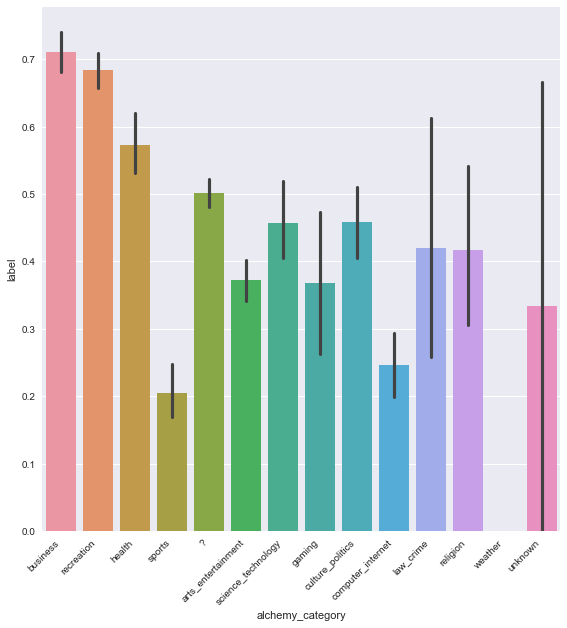

In [12]:
import seaborn as sb
%matplotlib inline

p = sb.factorplot(x='alchemy_category', 
              y='label',
              kind='bar',
              data = data,
              size = 8
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

> ### Exercise: 5. How many articles are there per category?

                    label
alchemy_category         
?                    2342
arts_entertainment    941
business              880
computer_internet     296
culture_politics      343
gaming                 76
health                506
law_crime              31
recreation           1229
religion               72
science_technology    289
sports                380
unknown                 6
weather                 4


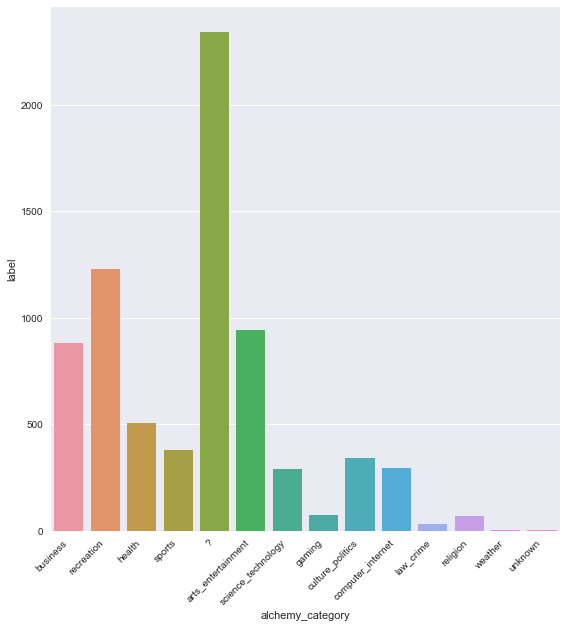

In [13]:
print data.groupby(['alchemy_category'])[['label']].count()

import seaborn as sb
%matplotlib inline

p = sb.factorplot(x='alchemy_category', 
              y='label',
              kind='bar',
              data = data,
              size = 8,
              estimator=len
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evergreen websites higher or lower on pages that have recipe in the the title?

#### Write a function called "has_recipe" that takes the parameter "text_in" 

1. Have the function look for the word 'recipe' in a string 
2. If the word "recipe" is present return 1, else return 0 
3. Not all articles will have the word, "recipe" so use the try/except syntax
4. Don't forget to deal with capitals str(word).lower()

In [14]:
def has_recipe(text_in):
    try: 
        if 'recipe' in str(text_in).lower():
            return 1
        else:
            return 0
    except:
        return 0

In [15]:
data['recipe'] = data['title'].map(has_recipe)

data['recipe']

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      1
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
7365    0
7366    0
7367    0
7368    0
7369    0
7370    0
7371    1
7372    0
7373    0
7374    0
7375    0
7376    1
7377    0
7378    1
7379    0
7380    1
7381    0
7382    0
7383    0
7384    0
7385    0
7386    0
7387    0
7388    0
7389    0
7390    0
7391    0
7392    0
7393    0
7394    0
Name: recipe, dtype: int64

In [16]:
data.groupby(['recipe'])[['label']].count()

,label
recipe,
0,6469
1,926


###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [17]:
from sklearn.tree import DecisionTreeClassifier

#### Specify model

In [18]:
model = DecisionTreeClassifier()

#### Set feature and outcome

In [19]:
X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

#### Fit model

In [20]:
model.fit(X, y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [21]:
from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(modeler):
    dotfile = open("tree.dot", 'w')
    export_graphviz(modeler, out_file = dotfile, feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.

In [22]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

/Users/Keshav/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


CV AUC [ 0.55190058  0.57822793  0.57546662  0.57655358  0.55612483], Average AUC 0.567654710265


###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [23]:
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
build_tree_image(model)

 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [56]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Demo: Extracting importance of features

In [41]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort('Importance Score', inplace=True, ascending=False)

features_df.head()

/Users/Keshav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Features,Importance Score
1,html_ratio,0.503325
0,image_ratio,0.406800
2,recipe,0.089875


 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [42]:
from sklearn.cross_validation import KFold, cross_val_score
k_fold = KFold(len(y), n_folds = 5, shuffle = True, random_state = 0)

for i in range(10,160,50): 
    new_model = RandomForestClassifier(n_estimators = i)
    print cross_val_score(new_model, X, y, cv=k_fold, n_jobs = 1) 



[ 0.56457066  0.58958756  0.58350237  0.57336038  0.59702502]
[ 0.57471264  0.58755916  0.5841785   0.58350237  0.59296822]
[ 0.58147397  0.58350237  0.58350237  0.58147397  0.59634888]


In [58]:
new_model.fit(X,y)
features = X.columns
feature_importances2 = new_model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances2})
features_df.sort('Importance Score', inplace=True, ascending=False)

features_df.head()

/Users/Keshav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Features,Importance Score
1,html_ratio,0.499732
0,image_ratio,0.411170
2,recipe,0.089098


##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature


In [59]:
New_model = RandomForestClassifier(n_estimators = 20)

New_X = data[["image_ratio","recipe","label"]]
New_y = New_X["label"]

New_X.drop("label", axis = 1, inplace = True)

new_scores = cross_val_score(new_model, New_X, New_y, scoring = "roc_auc")
print("Area Under Curve Scores "+ str(new_scores))


/Users/Keshav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Area Under Curve Scores [ 0.59062335  0.601278    0.59779395]


In [61]:
New_model.fit(New_X,New_y)
features3 = New_X.columns
feature_importances3 = New_model.feature_importances_

features3_df = pd.DataFrame({"Features": features3, "Importance Score": feature_importances3})
features3_df.sort("Importance Score", inplace = True, ascending = False)

features3_df.head()


/Users/Keshav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Features,Importance Score
0,image_ratio,0.885417
1,recipe,0.114583
